### Import Libraries

In [79]:
import pandas as pd
import numpy as np
from datetime import datetime

### Import data

In [80]:
data_folder = "../input/g-research-crypto-forecasting/"
!ls $data_folder

asset_details.csv	       example_test.csv  supplemental_train.csv
example_sample_submission.csv  gresearch_crypto  train.csv


In [81]:
crypto_df = pd.read_csv(data_folder + 'train.csv')

In [82]:
crypto_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


In [83]:
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


### Preprocessing

In [84]:
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp") # Asset_ID = 6 for Ethereum
eth.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956200 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Asset_ID  1956200 non-null  int64  
 1   Count     1956200 non-null  float64
 2   Open      1956200 non-null  float64
 3   High      1956200 non-null  float64
 4   Low       1956200 non-null  float64
 5   Close     1956200 non-null  float64
 6   Volume    1956200 non-null  float64
 7   VWAP      1956200 non-null  float64
 8   Target    1955860 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 149.2 MB


We can see the number of rows in the training set, and that there are missing values for the targets columns, which we will address later. Let's confirm that:


In [85]:
eth.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      340
dtype: int64

In [86]:
eth.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809
1514764920,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441
1514764980,6,120.0,738.3325,745.12,730.00,737.5025,174.138031,737.994457,-0.004206
1514765040,6,156.0,737.2225,744.69,728.93,737.1025,165.383926,737.303631,-0.002205
1514765100,6,118.0,736.5300,743.80,727.11,735.7050,193.078039,736.163026,-0.001744


In [87]:
beg_eth = eth.index[0].astype('datetime64[s]')
end_eth = eth.index[-1].astype('datetime64[s]')

print('Ethereum data goes from ', beg_eth, 'to ', end_eth)

Ethereum data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00


Missing asset data, for a given minute, is not represented by NaN's, but instead by the absence of those rows. We can check the timestamp difference between consecutive rows to see if there is missing data.

In [88]:
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60     1956043
120        100
180         23
300          5
540          4
Name: timestamp, dtype: int64

Notice that there are many gaps in the data. To work with most time series models, we should preprocess our data into a format without time gaps. To fill the gaps, we can use the `.reindex()` method for forward filling, filling gaps with the previous valid value. 

In [89]:
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')

And check that are no time gaps now.

In [90]:
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

### Data visualisation

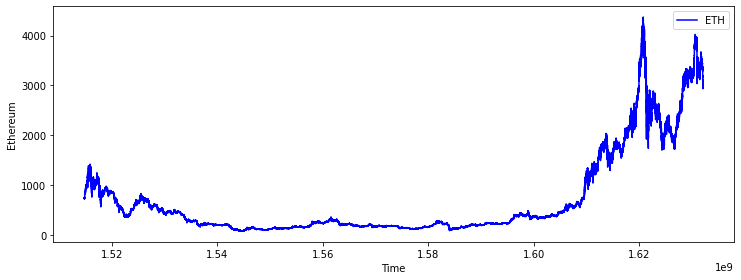

In [91]:
import matplotlib.pyplot as plt

# plot vwap time series for both chosen assets
f = plt.figure(figsize=(20,4))

# fill missing values for BTC
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')

ax = f.add_subplot(122)
ax.plot(eth['Close'], color='blue', label='ETH')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum')

plt.tight_layout()
plt.show()

In [92]:
import time

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# create intervals
eth_mini_2021 = eth.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]

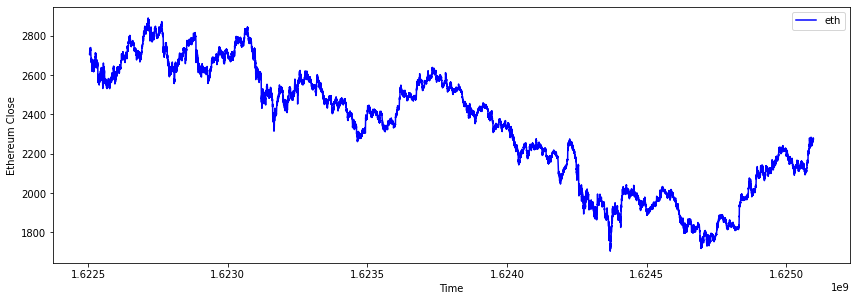

In [93]:
# plot time series for both chosen assets
f = plt.figure(figsize=(12,8))

ax = f.add_subplot(211)
ax.plot(eth_mini_2021['Close'], color='blue', label='eth')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum Close')

plt.tight_layout()
plt.show()

### Log returns

In [94]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

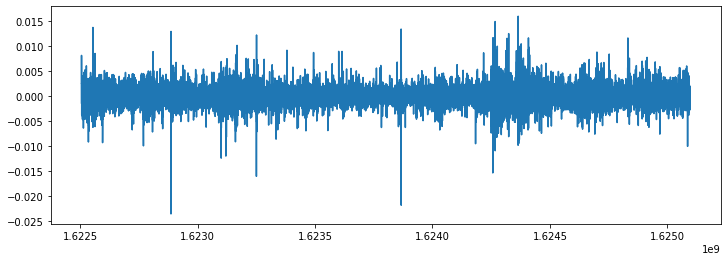

In [95]:
import scipy.stats as stats

lret_eth = log_return(eth_mini_2021.Close)[1:]
lret_eth.rename('lret_eth', inplace=True)

plt.figure(figsize=(12,4))
plt.plot(lret_eth);
plt.show()

### Correlation between assets

In [96]:
# create dataframe with returns for all assets
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  asset = crypto_df[crypto_df["Asset_ID"]==asset_id].set_index("timestamp")
  asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]
  asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
  lret = log_return(asset.Close.fillna(0))[1:]
  all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

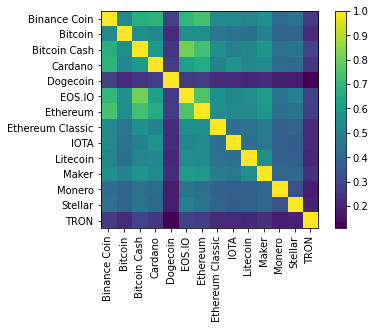

In [97]:
plt.imshow(all_assets_2021.corr());
plt.yticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values);
plt.xticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();

### Build prediction model

This forecasting aims to predict returns in the near future for prices $P^a$, for each asset $a$. For each row in the dataset, we include the target for prediction, `Target`. `Target` is derived from log returns ($R^a$) over 15 minutes.

$$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$
 
In more detail, if $M(t)$ is the weighted average market returns, the target is:

$$M(t) = \frac{\sum_a w^a R^a(t)}{\sum_a w^a}  \\
\beta^a = \frac{\langle M \cdot R^a \rangle}{\langle M^2 \rangle} \\
\text{Target}^a(t) = R^a(t) - \beta^a M(t)$$

where the bracket $\langle .\rangle$ represent the rolling average over time (3750 minute windows), and same asset weights $w^a$ used for the evaluation metric.

### Additional Feature design

Design a few relevant features to input to our model.

In [98]:
# Select some input features from the trading data: 
# 5 min log return, abs(5 min log return), upper shadow, and lower shadow.
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

X_eth = pd.concat([log_return(eth.VWAP,periods=5), log_return(eth.VWAP,periods=1).abs(), 
               upper_shadow(eth), lower_shadow(eth)], axis=1)
y_eth = eth.Target

### Prepare data for predictive modeling

In [99]:
# select training and test periods
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

In [100]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

### Baseline model - Linear Regression

In [101]:
from sklearn.linear_model import LinearRegression

# implement basic ML baseline (one per asset)
lr = LinearRegression()

lr.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled)

### Evaluate baseline

In [102]:
print('Test score for LR baseline: ETH', f"{np.corrcoef(y_pred_lr_eth, y_eth_test)[0,1]:.2f}")

Test score for LR baseline: ETH 0.02
